In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [205]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [206]:
df.shape

(100000, 9)

In [207]:
from sklearn.metrics import confusion_matrix
def confusion(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return cm

In [208]:
display(df.head())

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [209]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


None

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'hypertension'}>,
        <Axes: title={'center': 'heart_disease'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'HbA1c_level'}>,
        <Axes: title={'center': 'blood_glucose_level'}>],
       [<Axes: title={'center': 'diabetes'}>, <Axes: >, <Axes: >]],
      dtype=object)

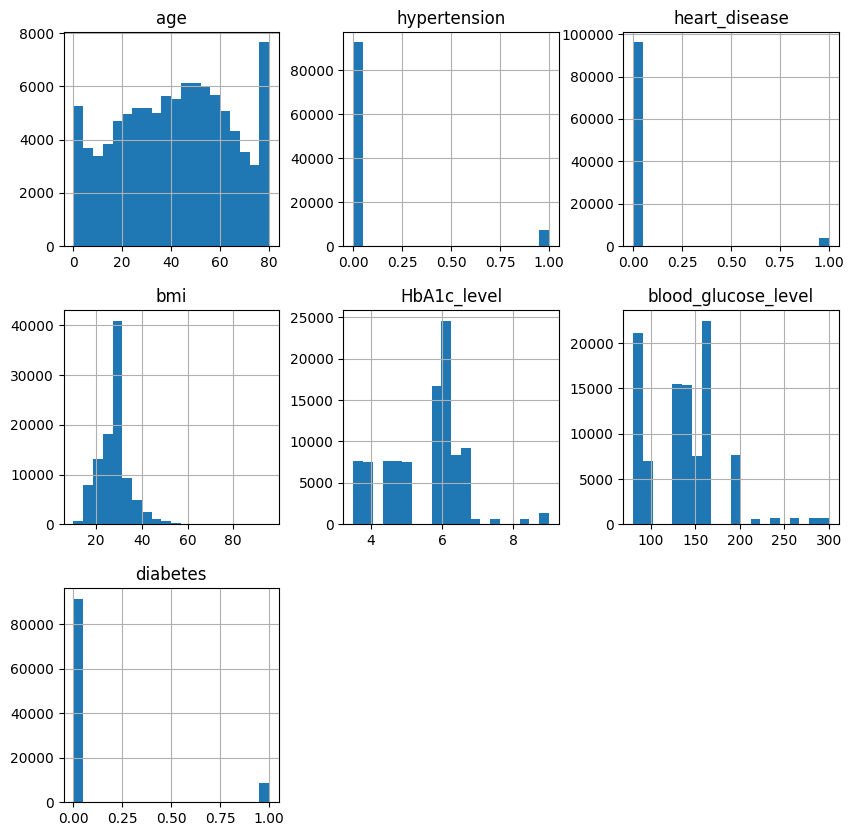

In [210]:
df.hist(figsize=(10,10), bins=20)

In [225]:
from sklearn.model_selection import train_test_split
training_column = 'diabetes'
drop_columns = [training_column]

X = df.drop(columns=drop_columns)
y = df[training_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Preprocessing

In [226]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

transformer = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']),
    ('cat', OneHotEncoder(), ['gender', 'smoking_history'])
])  

cat_transformer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), ['gender', 'smoking_history'])
])  

In [227]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

### Training and Hyperparameter Search

In [260]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score

pos = (y_train==1).sum()  # Getting the amount of positive diabetes
neg = (y_train==0).sum()  # Negative diabetes count
pos_weight = neg / pos    # XGBoost needs this weight to weigh the classes properly
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
}
param_grid = [
    {
        'classifier': [RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)],
        'classifier__n_estimators': [50, 100, 200, 600],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10, 20]

    },
    {
        "classifier": [xgb.XGBClassifier(
        random_state=42,
        scale_pos_weight=pos_weight, 
    )],
        "classifier__n_estimators": [300, 600, 700, 1500],
        "classifier__max_depth": [1, 3, 5, 7, 10, 20],
        "classifier__learning_rate": [0.001, 0.025, 0.1],
        "classifier__subsample": [0.3, 0.7, 1.0],
    },
    {
        'classifier': [HistGradientBoostingClassifier(class_weight='balanced', random_state=42)],
        'classifier__max_iter': [100, 200, 400],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__learning_rate': [0.03, 0.1, 0.2]
    }
]
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='recall', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [259]:
display(grid_search.best_params_)

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, ...),
 'classifier__learning_rate': 0.001,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 700,
 'classifier__subsample': 1.0}

In [248]:
index = grid_search.best_index_
print(f'Accuracy: {grid_search.cv_results_['mean_test_accuracy'][index]}')
print(f'Recall: {grid_search.cv_results_['mean_test_recall'][index]}')
print(f'F1 Score: {grid_search.cv_results_['mean_test_f1'][index]}')

Accuracy: 0.8553142857142857
Recall: 0.9380138150978276
F1 Score: 0.5244434778394325


In [256]:
confusion(grid_search, X_test, y_test)

array([[23335,  4118],
       [  172,  2375]])

### Hyperparameter effects

<Axes: xlabel='param_classifier__max_depth', ylabel='mean_test_recall'>

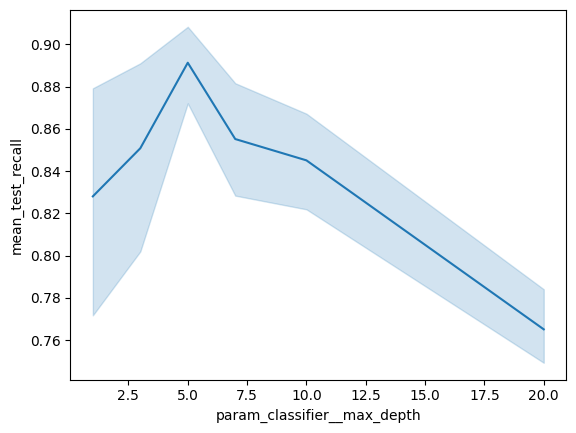

In [ ]:
cv = pd.DataFrame(grid_search.cv_results_)
sns.lineplot( data=cv, x="param_classifier__max_depth", y="mean_test_recall")

<Axes: xlabel='param_classifier__learning_rate', ylabel='mean_test_recall'>

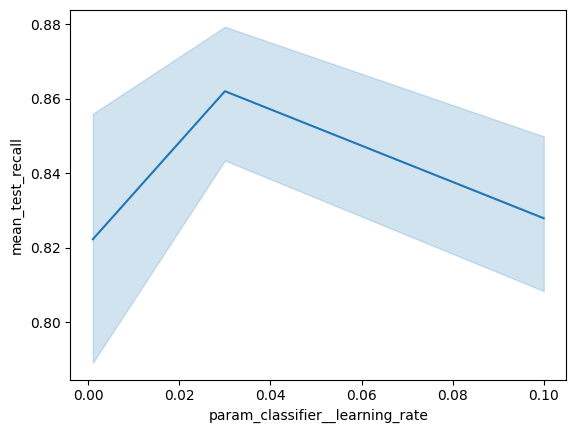

In [257]:
sns.lineplot( data=cv, x="param_classifier__learning_rate", y="mean_test_recall")

### Feature Importance
https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names

In [ ]:
best_model = grid_search.best_estimator_["classifier"]
features_messed = grid_search.best_estimator_.named_steps['transformer'].get_feature_names_out()
features = []
# Clean up names
for feat in features_messed:
    features.append(feat.strip("num").strip("cat").replace("_", " "))

<Axes: >

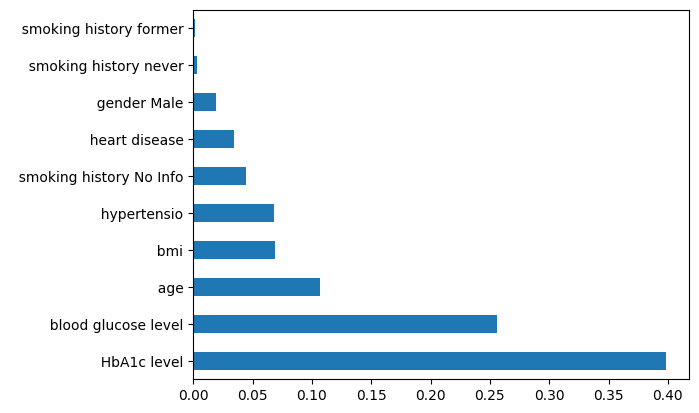

In [ ]:

feat_importances = pd.Series(best_model.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')

### Correlation
https://www.kaggle.com/code/lys620/tutorial-how-to-check-feature-importance

In [ ]:
# Converting string -> int
df["gender"] = df["gender"].astype("category").cat.codes
df["smoking_history"] = df["smoking_history"].astype("category").cat.codes
matrix = df.corr()
top_corr_feature = matrix.index

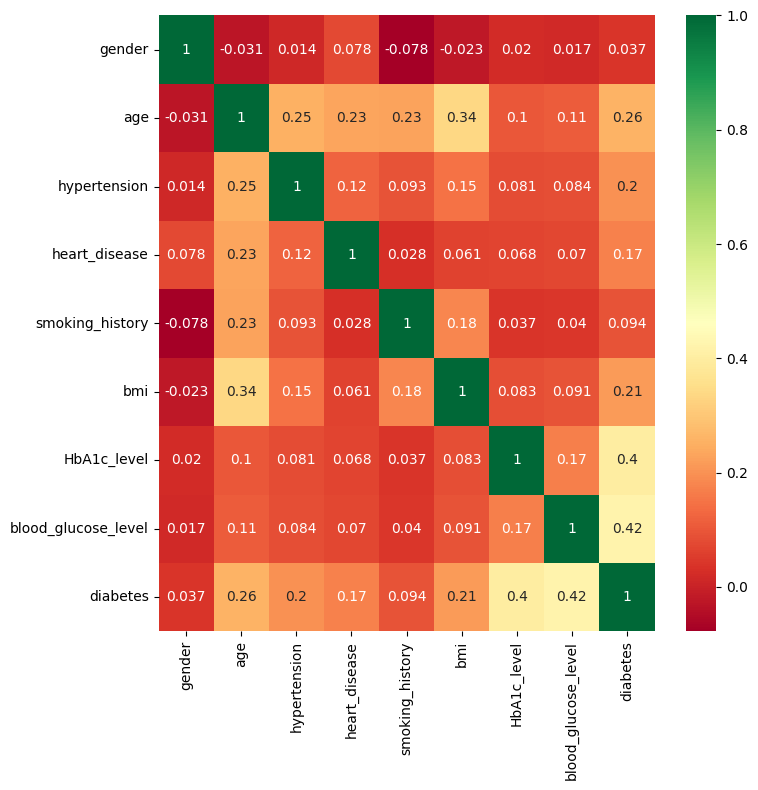

In [ ]:
plt.figure(figsize=(8,8))
g = sns.heatmap(df[top_corr_feature].corr(), annot=True, cmap='RdYlGn')

### Mutual Information
https://www.kaggle.com/code/ryanholbrook/mutual-information

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = df.copy()
y = X.pop("diabetes")

discrete_features = [True, False, True, True, True, False, False, False]  
# matches column order in X

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)

<Figure size 800x500 with 0 Axes>

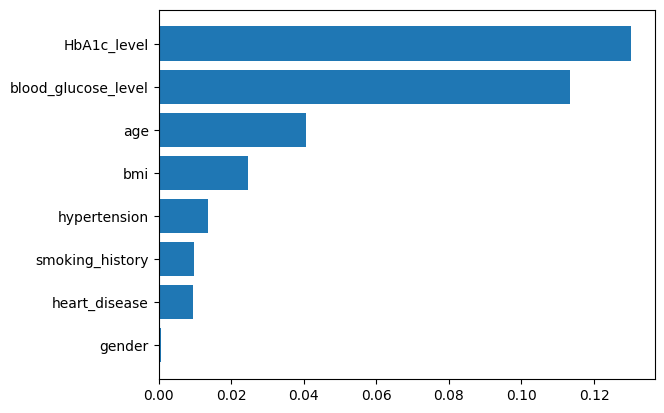

<Figure size 800x500 with 0 Axes>

In [164]:
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.figure(dpi=100, figsize=(8, 5))